<a href="https://colab.research.google.com/github/renferpur/Data-Science-for-Marketing-Analytics/blob/master/C%C3%B3pia_de_k_means_clustering_com_rfm_segmentation_clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-means em segmentação de clientes com variável RFM


Nesse notebook de exemplo da imersão vamos usar o famoso Online retail dataset do UCI Machine Learning Library, já que infelizmente a empresa não autorizou o uso do código por ser um projeto interno e confidencial.

In [ ]:
!pip install feature_engine
## importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import plotly.offline as pyoff
import plotly.graph_objs as go

import datetime as dt
import feature_engine

from feature_engine.outliers import Winsorizer

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 6.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# carregar o dataset
df = pd.read_csv('/content/drive/MyDrive/Online-Retail.csv',encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [ ]:
df.shape
#conferir os 541k de linhas

(541909, 8)

## Data Preparation

In [ ]:
## vou criar uma fórmula mais básica de check de dados aqui
def summary(df, pred=None):
  obs = df.shape[0]
  types = df.dtypes
  counts = df.apply(lambda x: x.count())
  min = df.min()
  uniques = df.apply(lambda x: x.unique().shape[0])
  nulls = df.apply(lambda x: x.isnull().sum())
  print('Data shape:', df.shape)

  if pred is None:
        cols = ['types', 'counts', 'uniques', 'nulls', 'min']
        str = pd.concat([types, counts, uniques, nulls, min], axis = 1, sort=True)

  str.columns = cols
  dtypes = str.types.value_counts()
  print('___________________________\nData types:')
  print(str.types.value_counts())
  print('___________________________')
  return str

details = summary(df) ##Entender como estão os dados, se há algum nulo
display(details.sort_values(by='nulls', ascending=False))

Data shape: (541909, 8)
___________________________
Data types:
object     5
float64    2
int64      1
Name: types, dtype: int64
___________________________


,types,counts,uniques,nulls,min
CustomerID,float64,406829,4373,135080,12346.0
Description,object,540455,4224,1454,NaN
Country,object,541909,38,0,Australia
InvoiceDate,object,541909,23260,0,1/10/2011 10:04
InvoiceNo,object,541909,25900,0,536365
Quantity,int64,541909,722,0,-80995
StockCode,object,541909,4070,0,10002
UnitPrice,float64,541909,1630,0,-11062.06


In [ ]:
df.describe()
##ver se os dados são skewed --- importante para implementação do K-means

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
#tem um preço estranho aqui> um preço negativo, veremos o que é:
df.loc[(df.UnitPrice<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


In [ ]:
df.loc[(df.Quantity<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


**Observation:**

- Há uma quantidade de pedido máxima que é muito estranha, favor olhar
- Unit price também há valores negativos

Vamos remover esses casos estranhos de preços e quantidades negativos com o negócio

In [ ]:
df.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Temos 25% das contas com CustomerID faltando. Caso não temos chance de achar quem é quem, dropamos os dados

Existe vários países, vamos deixar somente os de UK já que tem mais dados aqui

In [ ]:
df.Country.value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [ ]:
df = df[df.Country == 'United Kingdom']

**Removendo os valores negativos**

In [ ]:
df = df[df.Quantity > 0]
df = df[df.UnitPrice > 0]

#Removing the Null values from the data.
df = df[pd.notnull(df['CustomerID'])]

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df['Date'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [ ]:
df.isnull().mean()

InvoiceNo           0.0
StockCode           0.0
Description         0.0
Quantity            0.0
InvoiceDate         0.0
UnitPrice           0.0
CustomerID          0.0
Country             0.0
InvoiceYearMonth    0.0
Date                0.0
dtype: float64

**Já temos toda a info que precisamos para nosso RFM:**
- Customer ID
- Unit Price
- Quantity
- Invoice Date

**fazendo algumas agregações por mês**

In [ ]:
df_agg= df.groupby("Date").Quantity.sum()
df_agg

Date
2010-12    267767
2011-01    278251
2011-02    213375
2011-03    276304
2011-04    260448
2011-05    301824
2011-06    280974
2011-07    303601
2011-08    310831
2011-09    454559
2011-10    476984
2011-11    571215
2011-12    260607
Name: Quantity, dtype: int64

In [ ]:
#convertendo serie para dataframe e dando reset no index
df_agg=pd.DataFrame(df_agg)
df_agg=df_agg.reset_index()
df_agg.head()

,index,Date,Quantity
0,0,2010-12,267767
1,1,2011-01,278251
2,2,2011-02,213375
3,3,2011-03,276304
4,4,2011-04,260448


In [ ]:
#Fazer gráfico dos pedidos
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Orders', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x, y, color='tab:Purple', marker='o')
    plt.show()

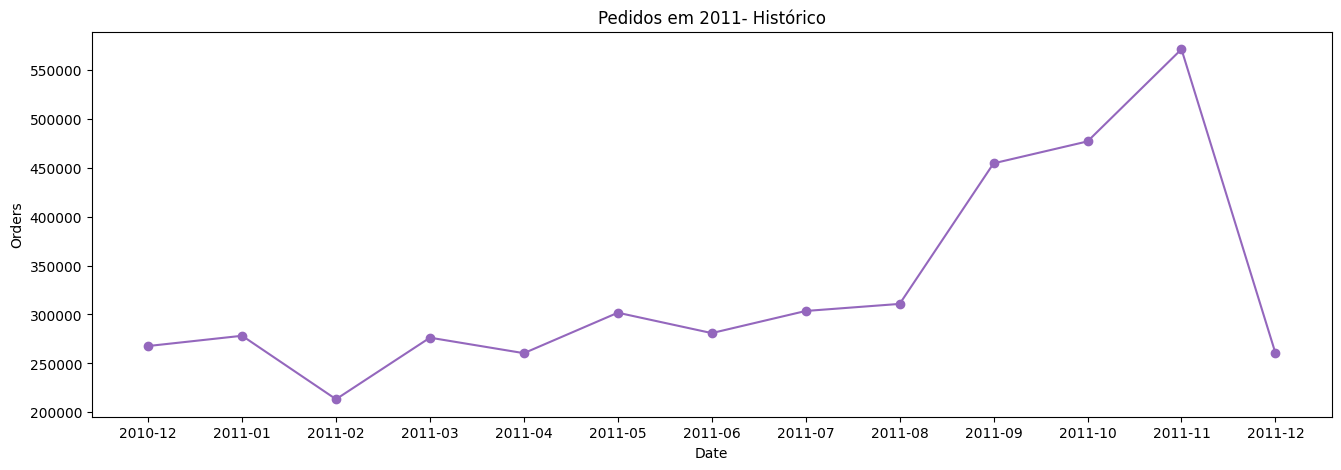

In [ ]:
plot_df(df_agg, x=df_agg.Date, y=df_agg.Quantity,title='Pedidos em 2011- Histórico')

### Calculando receita

**Revenue = Order Count * Average Revenue per Order**

In [ ]:
df['Revenue'] = df['Quantity']*df['UnitPrice']

<Axes: xlabel='Quantity'>

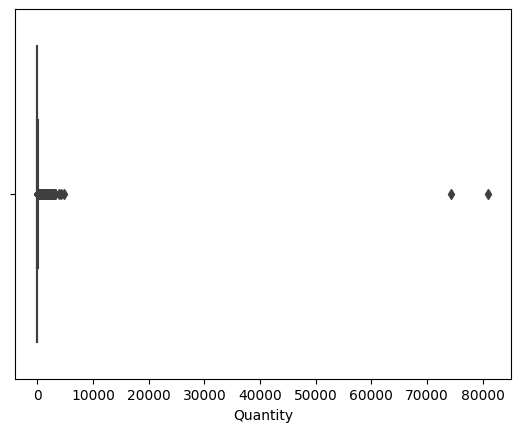

In [ ]:
sns.boxplot(x=df['Quantity'])

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Date,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12,20.34


Receita Mensal

In [ ]:
df_revenue = df.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
df_revenue.tail()

,InvoiceYearMonth,Revenue
8,201108,498453.320
9,201109,796780.272
10,201110,824766.220
11,201111,980645.750
12,201112,472384.170


In [ ]:
plot_data = [
    go.Scatter(
        x=df_revenue['InvoiceYearMonth'],
        y=df_revenue['Revenue'],
        mode='lines+markers'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Receita Mensal'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Análise RFM

<b>Recency-Frequency-Monetary

Vamos Fazer a versão no sheets, mas vamos colocar aqui também
    
  
  

<b>A ultima data do invoice é 2011–12–09,usaremos esse dado para calcular Recency.</b>

In [ ]:
##fazendo o download para o sheets:
from google.colab import drive
drive.mount('/content/drive')

  # Define the path where the CSV file will be saved
path = '/content/drive/My Drive/outputRFMimersao.csv'

# Format the specified column to two decimal places
df['Revenue'] = df['Revenue'].apply(lambda x: round(x, 2))
df['UnitPrice'] = df['UnitPrice'].apply(lambda x: round(x, 2))

with open(path, 'w', encoding='utf-8-sig') as f:
  df.to_csv(f, sep=',', decimal='.', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
NOW = pd.to_datetime('today').date()
##dt.date(2011,12,9)
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

In [ ]:
df


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Date,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12-01,20.34
...,...,...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,201112,2011-12-09,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,201112,2011-12-09,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,201112,2011-12-09,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,201112,2011-12-09,214.80


#### Recency

In [ ]:
##Vamos calcular a diferença em dias da data de hoje e a data que está na compra - vai dar bastante diferença pois é 2011. Você pode considerar a ultima data do invoice se quiser para ficar menos numero longo. Não compromete o método
df_recency = df.groupby(['CustomerID'],as_index=False)['Date'].max()
df_recency.columns = ['CustomerID','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,CustomerID,Recency
0,12346.0,4685
1,12747.0,4362
2,12748.0,4360
3,12749.0,4363
4,12820.0,4363


#### Frequency - Monetarty

In [ ]:
FM_Table = df.groupby('CustomerID').agg({'InvoiceNo'   : lambda x:len(x),
                                         'Revenue'  : lambda x:x.sum()})
FM_Table.rename(columns = {'InvoiceNo' :'Frequency',
                           'Revenue':'Monetary'},inplace= True)
FM_Table.head()

#Frequencia é a quantidade de compra, enquanto o monetary é a soma das receitas

,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12747.0,103,4196.01
12748.0,4595,33719.73
12749.0,199,4090.88
12820.0,59,942.34


In [ ]:
RFM_Table = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,4685,1,77183.60
1,12747.0,4362,103,4196.01
2,12748.0,4360,4595,33719.73
3,12749.0,4363,199,4090.88
4,12820.0,4363,59,942.34


<b> Nós vamos dividir as métricas em segmentos usando percentis. Aqui vamos usar percentil de 20%, assim dividindo a base em 5 etapas diferentes.</b>


In [ ]:
quantiles = RFM_Table.quantile(q=[0.2,0.4,0.6,0.8])
quantiles = quantiles.to_dict()

In [ ]:
segmented_rfm = RFM_Table.copy()

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 2
    else:
        return 1

def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 4
    else:
        return 5

In [ ]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile
0,12346.0,4685,1,77183.60,1,1,5
1,12747.0,4362,103,4196.01,5,4,5
2,12748.0,4360,4595,33719.73,5,5,5
3,12749.0,4363,199,4090.88,5,5,5
4,12820.0,4363,59,942.34,5,4,4


**Calculando o RFM combinado**

RFM_Score = R_quartile + F_quartile + M_quartile

In [ ]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)

In [ ]:
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score,RFM_Segment
0,12346.0,4685,1,77183.60,1,1,5,7,115
1,12747.0,4362,103,4196.01,5,4,5,14,545
2,12748.0,4360,4595,33719.73,5,5,5,15,555
3,12749.0,4363,199,4090.88,5,5,5,15,555
4,12820.0,4363,59,942.34,5,4,4,13,544


In [ ]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

In [ ]:
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score,RFM_Segment
0,12346.0,4685,1,77183.60,1,1,5,7,115
1,12747.0,4362,103,4196.01,5,4,5,14,545
2,12748.0,4360,4595,33719.73,5,5,5,15,555
3,12749.0,4363,199,4090.88,5,5,5,15,555
4,12820.0,4363,59,942.34,5,4,4,13,544


In [ ]:
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Almost Lost: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  233
Loyal Customers:  803
Big Spenders:  784
Almost Lost:  17
Lost Customers:  71
Lost Cheap Customers:  106


In [ ]:
segmented_rfm['RFM_Score'].unique()

array([ 7, 14, 15, 13,  3, 10,  9, 12,  4, 11,  8,  6,  5])

In [ ]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3          4632.4       6.5    131.1   233
4          4566.8      10.9    195.5   239
5          4540.9      16.0    277.7   338
6          4486.4      19.7    350.4   353
7          4467.8      27.1    934.9   342
8          4446.1      36.3    601.8   335
9          4427.0      45.9    862.9   336
10         4417.0      62.2   1022.2   316
11         4404.5      81.3   1975.1   295
12         4393.0     111.8   1692.2   300
13         4383.2     143.5   3035.7   280
14         4374.2     226.7   4033.8   270
15         4364.8     432.5  10070.2   283

## K-means para fazer melhor (Recency, Frequency, and Monetary) segmentação por usuário


<b>Quando K-means dá bons resultados</b>
- <b>Quando a distribuição não está skewed </b>
- <b> Dado está normalizado (i.e. Média de 0 e desvio padrão de 1).</b>

**Checar skewness**




In [ ]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 1.2445164946864906, : SkewtestResult(statistic=25.28372005897832, pvalue=4.824648172206018e-141)
Frequency's: Skew: 18.66163311873067, : SkewtestResult(statistic=80.10349526126947, pvalue=0.0)
Monetary's: Skew: 20.190728786919397, : SkewtestResult(statistic=81.75346911674468, pvalue=0.0)


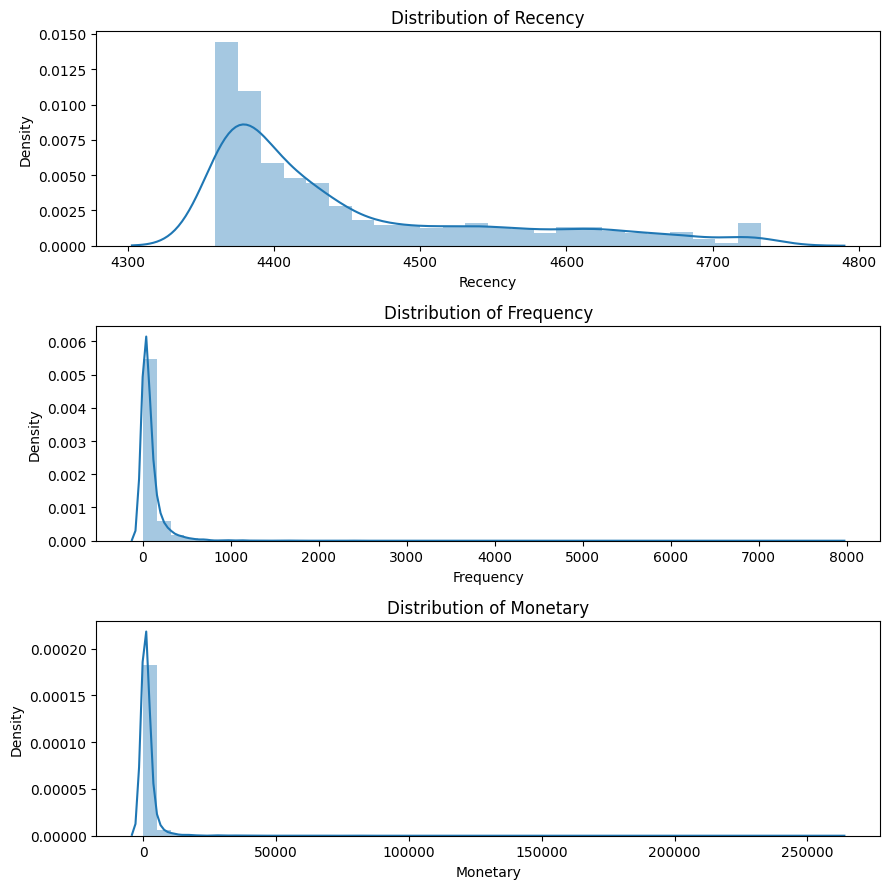

In [ ]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary')

plt.tight_layout()

<b>Dados são com alta skewness então vamos fazer algumas transformações para deixar os dados mais de acordo com os critérios do K-means</b>

In [ ]:
df_rfm_log = RFM_Table.copy()

In [ ]:
df_rfm_log.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,4685,1,77183.60
1,12747.0,4362,103,4196.01
2,12748.0,4360,4595,33719.73
3,12749.0,4363,199,4090.88
4,12820.0,4363,59,942.34


Recency's: Skew: 1.2153673630058799, : SkewtestResult(statistic=24.870031925118937, pvalue=1.570294987115668e-136)
Frequency's: Skew: -0.02600696239989871, : SkewtestResult(statistic=-0.6659021000684195, pvalue=0.5054736781086501)
Monetary's: Skew: 0.3694308315669854, : SkewtestResult(statistic=9.16608883300317, pvalue=4.9049270574031346e-20)


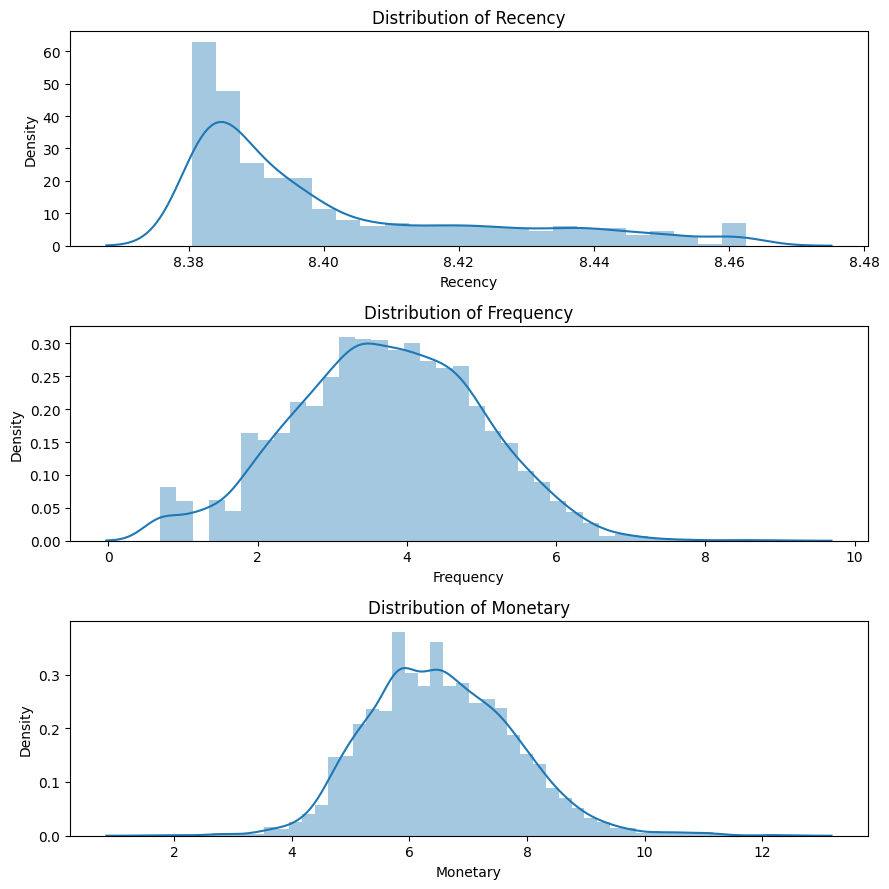

In [ ]:
df_rfm_log = np.log(df_rfm_log+1) ##log transformation

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()

In [ ]:
RFM_Table.describe()

,CustomerID,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,4451.742092,90.388010,1864.385599
std,1576.594671,99.533485,217.808385,7482.817477
min,12346.000000,4360.000000,1.000000,3.750000
25%,14208.750000,4377.000000,17.000000,300.280000
50%,15569.500000,4410.000000,41.000000,652.280000
75%,16913.250000,4502.000000,99.250000,1576.585000
max,18287.000000,4733.000000,7847.000000,259657.300000


In [ ]:
windsoriser = Winsorizer(tail='both', # cap left, right or both tails
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [ ]:
df_rfm_log = windsoriser.transform(df_rfm_log)

**Agora que reduzimos o skewness bora também normalizar os dados, para isso vamos usar o StandardScaler.**

In [ ]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

In [ ]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)
RFM_Table_scaled.head()

,CustomerID,Recency,Frequency,Monetary
0,-2.216570,2.173201,-2.075553,2.144184
1,-1.903521,-0.947470,0.758501,1.551863
2,-1.902753,-0.969750,2.072989,2.144184
3,-1.901985,-0.936334,1.296773,1.530119
4,-1.847594,-0.936334,0.305737,0.272403


## K-Means Clustering

### Finding the optimal number of clusters

In [ ]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1,10)

for k in K:
    #Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled)
    kmeanModel.fit(RFM_Table_scaled)

    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_,
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_,
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]
    mapping2[k] = kmeanModel.inertia_

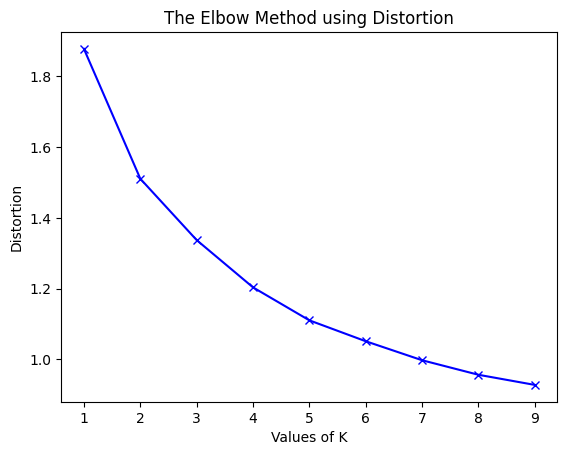

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

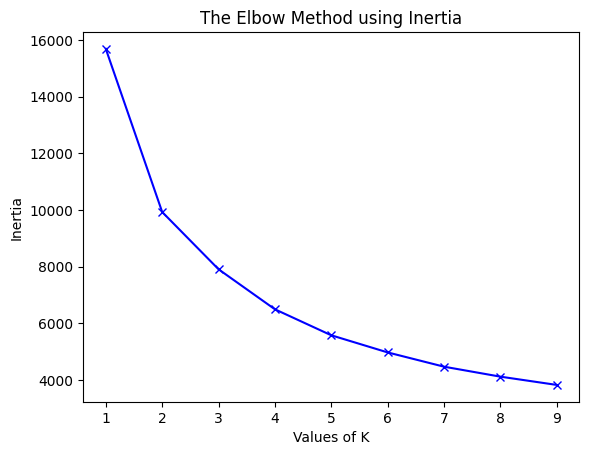

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

<b>The cluster value where this decrease in inertia value becomes constant can be chosen as the right cluster value for our data. Looking at the above elbow curve, we can choose any number of clusters between 4 to 7. Não vamos escolher um número muito longo de clusters para evitar overfitting portanto eu iria até um 5 no máximo</b>

In [ ]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):

    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_

    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)

    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)

    # Plot t-SNE
    plt.title('Curva flat de {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Paired")

    return df_new

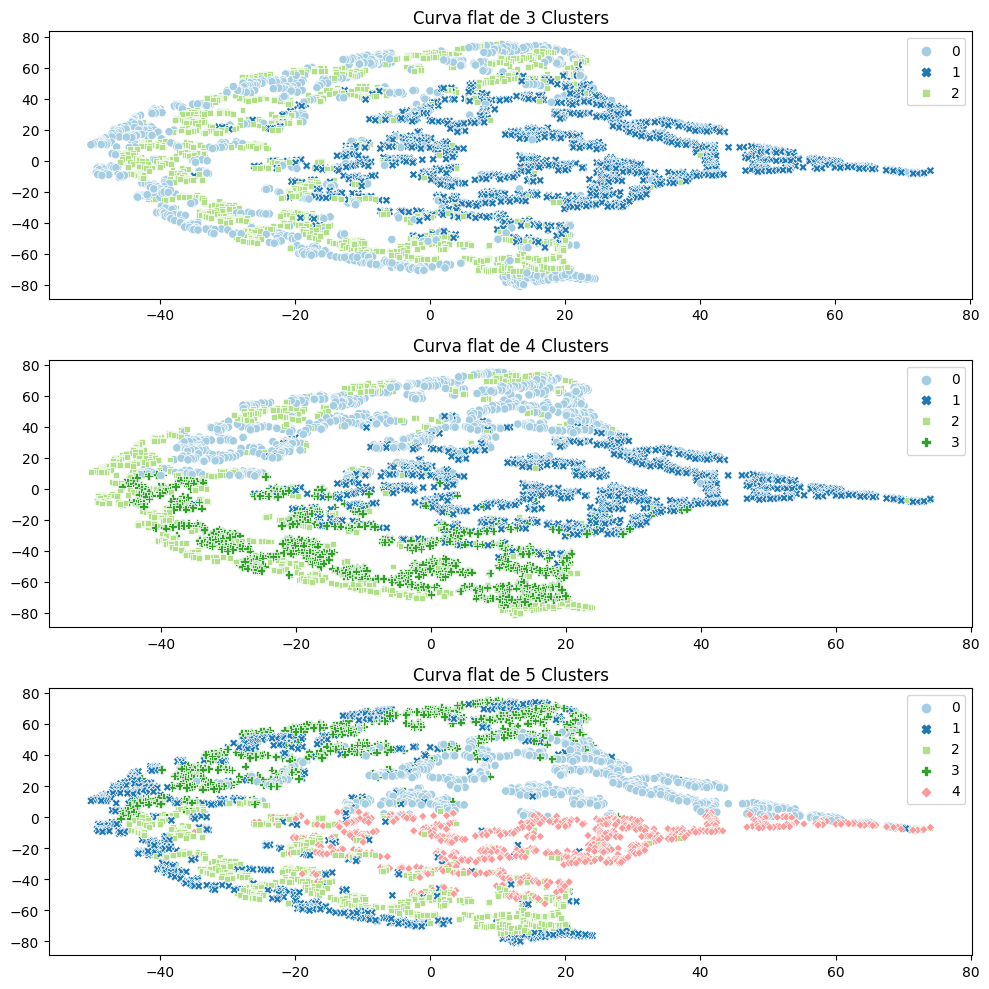

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)

plt.tight_layout()


In [ ]:
##Faço também outra visualização pelo Snake plot
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm,
                                       index=RFM_Table.index,
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(),
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'],
                        var_name='Metric',
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')

    return

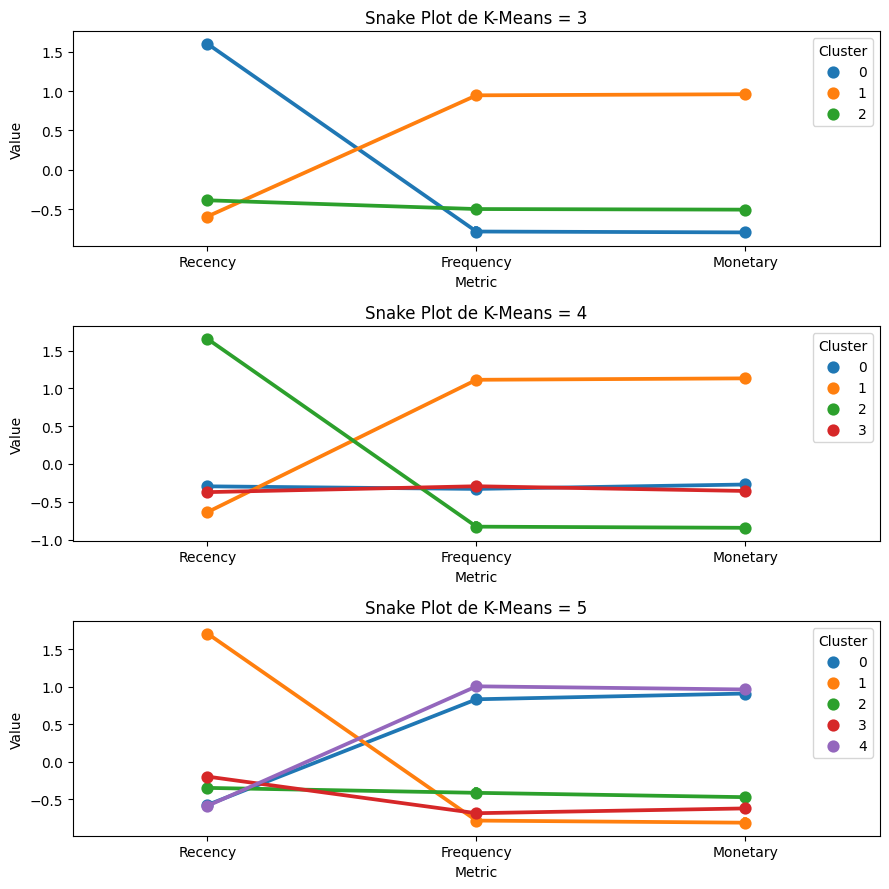

In [ ]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot de K-Means = 3')
snake_plot(RFM_Table_scaled, df_rfm_k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot de K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot de K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM_Table)

plt.tight_layout()

Podemos ver que a partir do 4 clusters fica legal, mas vou nessa situação fazer 5. Também podemos calcular o sillouette score e ver qual seria o número apropriado de clusters


### Interpretação dos 5 clusters.


In [ ]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)

    return df_new

In [ ]:
rfm_values(df_rfm_k5)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        4396.0     175.0   3391.0   793
1        4622.0      22.0    545.0   793
2        4416.0      32.0    705.0   855
3        4430.0      23.0    425.0   692
4        4395.0     197.0   4180.0   787

## O que cada cluster representa?

O cluster 4 seria o cluster de clientes que mais são frequentes, São recentes e ao mesmo tempo também dão dinheiro, contudo fazem um tempo que não compram de nós -- Esses são um dos melhores clientes que você tem que reter


O cluster 0 é o nosso segundo maior cluster. ele possui compras recentes, mas a frequencia e o dinheiro não são tão maiores que os 4. Esses são os core. Uma segunda opção para LL audience.

O cluster 1 ele o os Clientes menos recentes não compram muito e dão pouco dinheiro comparado aos outros. Esse você pode considerar como os clientes que dão menos LTV. Você deve fazer campanhas para reativá-los, enviar promoções com descontos e fazer um crosssell potencial.

O cluster 2 apesar de ser relativamente recente ele dá um pouco de dinheiro a mais e pode ter chances de virar um core user. Faria recomendações de novos produtos para ele, testaria upssell e não optaria por descontos aqui.

O cluster 3 é um pouco recente, mas não dá dinheiro nenhuma e pouco frequente. Esse você possui riscos de perdê-lo. Podemos fazer Campanhas de reativação, surveys,
descontos, ofertas limitadas

